In [21]:
import os
import torch
import torch as tc
import torch.nn as nn
import torch.autograd
from sklearn.manifold import TSNE
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import random
import numpy as np
from torch.distributions.uniform import Uniform
from torch.distributions.bernoulli import Bernoulli
from sklearn.neighbors import KNeighborsClassifier

In [22]:
data_with_names = pd.read_csv('../data2/TCPA_data_sel.csv')
ID, data = data_with_names.iloc[:,:2], tc.tensor(data_with_names.iloc[:,2:].values)


In [23]:
tsne = TSNE().fit_transform(data)
dataforplot = np.vstack((tsne.T, ID['Tumor'])).T
tsne_df = pd.DataFrame(data=dataforplot, columns = ('d1','d2','label'))

/home/pgk/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


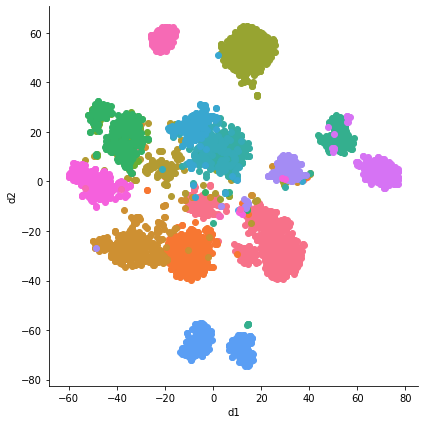

In [29]:
sn.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'd1', 'd2')

In [30]:
# run data thorugh saved neural net

In [4]:
data_with_names = pd.read_csv('../data2/TCPA_data_sel.csv')
ID, data = data_with_names.iloc[:,:2], tc.tensor(data_with_names.iloc[:,2:].values)

net = tc.load('recursivenet.pt').cuda()
net.repeats = 40
data = data.cuda().float()

/home/pgk/.local/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/pgk/.local/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'RecursiveNet.ResBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/pgk/.local/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source 

In [25]:
postdata = tc.zeros(data.shape).cuda()
with tc.no_grad():
    for t in range(1,300):
        #print(t)
        mask = Bernoulli(tc.ones(data.shape)*0.3).sample()
        mask = mask.cuda()
        postdata = (t-1)/t * postdata + 1/t * net(data, mask)
        
#maybe slightly better with p=0.5, try p=0.9, 

In [19]:
postdata = data.cuda()
with tc.no_grad():
    for t in range(1,10):
        print(t)
        mask = Bernoulli(tc.ones(data.shape)*0.95).sample()
        mask = mask.cuda()
        postdata = net(postdata, mask)

1
2
3
4
5
6
7
8
9


In [11]:
print(net.recursivenet.mean_layer)

Linear(in_features=189, out_features=1024, bias=True)


In [12]:
data = data.cuda()
with tc.no_grad():
    postdata = net.recursivenet.mean_layer(net.recursivenet.enc(data))

In [13]:
print(postdata.shape)


torch.Size([4730, 1024])


In [14]:
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
tumorlist = np.array(ID)[:,1]
#######################
random_state = random.randint(1,10000)
dataprior = np.array(data.cpu())
Xtrain,Xtest, ytrain, ytest = train_test_split(dataprior, tumorlist, random_state=random_state)
#print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

model = LogisticRegression()
model.fit(Xtrain, ytrain)
print('train:', model.score(Xtrain, ytrain))
print('test:', model.score(Xtest, ytest))

##########################
protdata = postdata.cpu().numpy()
Xtrain,Xtest, ytrain, ytest = train_test_split(protdata, tumorlist, random_state=random_state)
#print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

model2 = LogisticRegression()
model2.fit(Xtrain, ytrain)
print('posttrain:', model2.score(Xtrain, ytrain))
print('posttest:', model2.score(Xtest, ytest))

/home/pgk/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/pgk/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train: 0.986749365661122
test: 0.9526627218934911


/home/pgk/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/pgk/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


posttrain: 0.8937129968987877
posttest: 0.8884192730346576


In [17]:
tsne = TSNE().fit_transform(postdata.cpu())
dataforplot = np.vstack((tsne.T, ID['Tumor'])).T
tsne_df_post = pd.DataFrame(data=dataforplot, columns = ('d1','d2','label'))

/home/pgk/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/pgk/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


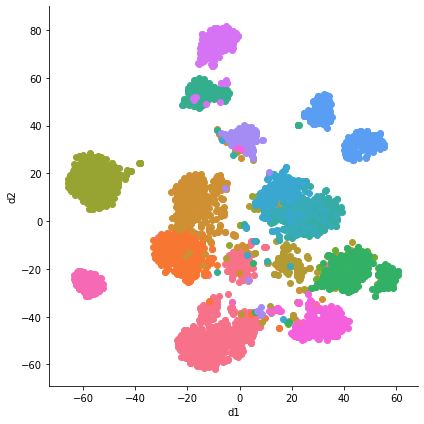

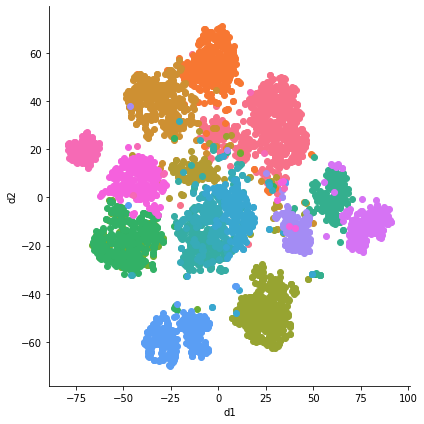

In [24]:
sn.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'd1', 'd2')
sn.FacetGrid(tsne_df_post, hue='label', size=6).map(plt.scatter, 'd1', 'd2')


In [3]:
from torch.utils.data import Dataset, DataLoader
data.shape
class DataSet(Dataset):
    def __init__(self,data):
        self.data = data
        self.len = data.size(0)
        
    def __getitem__(self,idx):
        false_idx = random.choice(list(range(idx)) + list(range(idx,self.len)))
        
        return self.data[idx,:].float(), self.data[false_idx,:].float()  
    
    def __len__(self):
        return self.len
    


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Dropout(p=0),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(p=0),
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self,x):
        return(self.layers(x))
    
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self,x):
        return(F.sigmoid(self.layers(x)))
    
class JS_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(JS_Discriminator,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self,x):
        return(F.sigmoid(self.layers(x)))
    


In [10]:
device = torch.device('cuda:0')
representation_size = 10

dataset = DataSet(data)
Dataloader = DataLoader(dataset, batch_size = 2000, shuffle=True)


test_example,false_example = next(iter(Dataloader))


In [6]:
encoder = Encoder(data.size(1), 512, representation_size)
discriminator = Discriminator(data.size(1) + representation_size, 60,1)
jsdiscriminator = JS_Discriminator(representation_size, 60, 1)


In [7]:
encoder.cuda()
discriminator.to(device)
jsdiscriminator.to(device)

JS_Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [11]:
optim_discriminator = tc.optim.Adam(discriminator.parameters(), lr= 0.0001)
optim_encoder = tc.optim.Adam(encoder.parameters(), lr=0.001)
optim_jsdiscriminator = tc.optim.Adam(jsdiscriminator.parameters(), lr=0.0001)


In [12]:
def train(n_epochs):
    for j in range(n_epochs):
        for i,(correct_data, false_data) in enumerate(Dataloader):
            correct_data = correct_data.cuda()
            false_data =false_data.cuda()
            optim_discriminator.zero_grad(), optim_encoder.zero_grad(), optim_jsdiscriminator.zero_grad()

            representation = encoder(correct_data)

            pos_samples = tc.cat((correct_data, representation), dim=1)
            neg_samples = tc.cat((false_data, representation), dim=1)

            pos_discrimination = discriminator(pos_samples)
            neg_discrimination = discriminator(neg_samples)
            
            random_representation = tc.rand(representation.shape).cuda()
            
            loss1 = -(pos_discrimination.mean(dim=0) - tc.log(tc.exp(neg_discrimination).mean(dim=0)))
            loss2 = tc.log(jsdiscriminator(random_representation)).mean(dim=0) + tc.log(1-jsdiscriminator(representation)).mean(dim=0)
            
            if i%1 == 0:
                loss = loss1 - loss2
                
                loss.backward()

                optim_discriminator.step() 

                optim_jsdiscriminator.step()
            
            else: 
                loss = loss1 + loss2
                loss.backward()

                optim_encoder.step() 
                
        if j%10 == 0: print(loss1, loss2)


    
    
    
    
    

In [13]:
torch.cuda.set_device(0)
train(500)

/home/pgk/.local/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.0096], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4499], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0076], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4497], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0061], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4444], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0050], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4435], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0044], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4426], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0040], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4384], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0036], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4360], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0033], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4337], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0028], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.4322

tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3931], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3933], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3939], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3931], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3930], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3928], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3930], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0003], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3924], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.0004], device='cuda:0', grad_fn=<NegBackward>) tensor([-1.3928

KeyboardInterrupt: 

In [16]:
with tc.no_grad():
    encoded_data = encoder(data.float().clone().detach()).cpu()



RuntimeError: CUDA error: an illegal memory access was encountered

In [17]:
encoded_data

NameError: name 'encoded_data' is not defined

In [18]:
import numpy as np
tsne = TSNE().fit_transform(np.array(encoded_data))
dataforplot = np.vstack((tsne.T, ID['Tumor'])).T
tsne_df = pd.DataFrame(data=dataforplot, columns = ('d1','d2','label'))
sn.FacetGrid(tsne_df, hue='label', height=6).map(plt.scatter, 'd1', 'd2')

NameError: name 'encoded_data' is not defined